In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
import numpy as np

import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt

from Bio import Entrez
from Bio import ExPASy
from Bio import SwissProt
Entrez.email = "user@gmail.com"

### Get SCAN domain location

In [2]:
def fetch_uniprot_record(uniprot_id):
    with ExPASy.get_sprot_raw(uniprot_id) as handle:
        return SwissProt.read(handle)

def get_domain_indices(uniprot_record):
    domain_indices = {}
    for feature in uniprot_record.features:
        if feature.type == 'DOMAIN':
            domain_indices[feature.qualifiers['note']] = [feature.location.start, feature.location.end]
    return domain_indices

In [3]:
target_protein_uniprot = fetch_uniprot_record('P28698')
domains = get_domain_indices(target_protein_uniprot)

start_scan, end_scan = domains['SCAN box']

### Load in datasets

In [4]:
cmut = pd.read_csv('../data/cancermuts_MZF1.csv')
alphamissense = pd.read_csv('../data/alphamissense/P28698/alphamissense_P28698.tsv', sep='\t')

In [5]:
# Select only scan domain residues from cancermuts dataset

# Select subset of cmut, which contains only mutations in the SCAN box
cmut_scan = cmut[(cmut['aa_position'] >= start_scan) & (cmut['aa_position'] <= end_scan)]

# Drop all rows with missing values in alt_aa
#cmut_scan = cmut_scan.dropna(subset=['alt_aa'])

# Reset index
cmut_scan = cmut_scan.reset_index(drop=True)

# Count number of rows
n_mutations = cmut_scan.shape[0]


In [6]:
cmut_scan_muts = []
for index, row in cmut_scan.iterrows():
        # Get the mutation
        ref_aa = row['ref_aa']
        mut_pos = row['aa_position']
        mut_aa = row['alt_aa']

        #print(type(mut_aa), mut_aa)

        if type(mut_aa) != float:       # Float are NaN values
                cmut_scan_muts.append(f'{ref_aa}{mut_pos}{mut_aa}')


### Load in energies for P28698 mutatex alone

In [7]:
P28698_energies = pd.read_csv('../data/mutatex/all_energies/P28698_scand_energies.csv')

### Load in ddgs for proteins complexes with P28698

In [8]:
# P28698 complexes with itself has a bit different output in residue # column
P28698_complex_energies = pd.read_csv('../data/mutatex/all_energies/P28698_P28698_scand_complex_energies.csv')

# Convert Residue # to number preceeding '_' in Residue # column
P28698_complex_energies['Residue #'] = P28698_complex_energies['Residue #'].str.extract(r'(\d+)')

# Convert dtype from string to int in Residue #
P28698_complex_energies['Residue #'] = P28698_complex_energies['Residue #'].astype(int)

In [9]:
# Load in other complexes
O95125_complex_energies = pd.read_csv('../data/mutatex/all_energies/O95125_P28698_scand_complex_energies.csv')
P17028_complex_energies = pd.read_csv('../data/mutatex/all_energies/P17028_P28698_scand_complex_energies.csv')
P57086_complex_energies = pd.read_csv('../data/mutatex/all_energies/P57086_P28698_scand_complex_energies.csv')
Q15697_complex_energies = pd.read_csv('../data/mutatex/all_energies/Q15697_P28698_scand_complex_energies.csv')
Q8NBB4_complex_energies = pd.read_csv('../data/mutatex/all_energies/Q8NBB4_P28698_scand_complex_energies.csv')


# Add start_scan to Residue # to get canonical residue number of the P28698 protein scan domain
P28698_complex_energies['Residue #'] = P28698_complex_energies['Residue #'] + start_scan
O95125_complex_energies['Residue #'] = O95125_complex_energies['Residue #'] + start_scan
P17028_complex_energies['Residue #'] = P17028_complex_energies['Residue #'] + start_scan
P57086_complex_energies['Residue #'] = P57086_complex_energies['Residue #'] + start_scan
Q15697_complex_energies['Residue #'] = Q15697_complex_energies['Residue #'] + start_scan
Q8NBB4_complex_energies['Residue #'] = Q8NBB4_complex_energies['Residue #'] + start_scan



In [10]:
energies_df_dict = {'P28698': P28698_energies,
                    'P28698_complex': P28698_complex_energies,
                    'O95125_complex': O95125_complex_energies,
                    'P17028_complex': P17028_complex_energies,
                    'P57086_complex': P57086_complex_energies,
                    'Q15697_complex': Q15697_complex_energies,
                    'Q8NBB4_complex': Q8NBB4_complex_energies}

AMINO_ACIDS = ['G', 'A', 'V', 'L', 'I', 'M', 'F', 'W', 'P', 'S', 'T', 'C', 'Y', 'N', 'Q', 'D', 'E', 'K', 'R', 'H']
DESTABILITY_THRESHOLD = 3

Identify stabilizing mutations for each protein

In [11]:
stabilizing_residues = {}
muta_tested_count = 0
destabilizing_count = 0
for protein, energy_df in energies_df_dict.items():
    # Make a list of all mutation outside stability threshold
    stabilizing_df = pd.DataFrame(columns=['mutation', 'ddg'])
    muta_tested_count += energy_df.shape[0]*20

    for row in energy_df.iterrows():
        row_data = row[1]
        wt_aa = row_data['WT residue type']
        
        mutations = []
        ddgs = []
        for aa in AMINO_ACIDS:
            if row_data[aa] > DESTABILITY_THRESHOLD:
                mutations.append(f'{wt_aa}{row_data["Residue #"]}{aa}')
                ddgs.append(row_data[aa])

        stabilizing_df_current = pd.DataFrame({'mutation': mutations, 'ddg': ddgs})
        stabilizing_df = pd.concat([stabilizing_df, stabilizing_df_current])
    
    destabilizing_count += stabilizing_df.shape[0]
    stabilizing_residues[protein] = stabilizing_df

muta_tested_count, destabilizing_count

/tmp/ipykernel_703/2173999154.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stabilizing_df = pd.concat([stabilizing_df, stabilizing_df_current])
/tmp/ipykernel_703/2173999154.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stabilizing_df = pd.concat([stabilizing_df, stabilizing_df_current])
/tmp/ipykernel_703/2173999154.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or al

(8920, 800)

Filter stabilizing mutations only present in either cmut or alphamissense

In [12]:
num_mut_per_res_alphamissense = 19
alphamissense_scan = alphamissense.iloc[num_mut_per_res_alphamissense*start_scan: num_mut_per_res_alphamissense*end_scan, :]



alphamissense_pathogenic = alphamissense_scan[alphamissense_scan['am_class'] == 'pathogenic']

In [13]:
alphamissense_scan.shape, alphamissense_pathogenic.shape

((1558, 4), (603, 4))

In [28]:
print('num mutations in cancermuts', len(cmut_scan_muts))
cmut_scan_muts

num mutations in cancermuts 40


['R44C',
 'R44H',
 'L45M',
 'R46C',
 'R46H',
 'F47S',
 'R48Q',
 'R48W',
 'R51H',
 'G57R',
 'G57W',
 'P58L',
 'A63T',
 'C69Y',
 'R70H',
 'R70L',
 'Q71R',
 'R74C',
 'R74H',
 'P75T',
 'R78C',
 'M83V',
 'L86V',
 'E90G',
 'G94S',
 'A95T',
 'P97L',
 'E99K',
 'E99Q',
 'I100N',
 'A102T',
 'G106W',
 'R108L',
 'E113G',
 'E113K',
 'E114K',
 'L118P',
 'R123C',
 'R124L',
 'E125K']

In [31]:

stabilizing_residues_classes = {}
for protein, stabilizing_df in stabilizing_residues.items():
    # Check if mutation is in cancermuts dataset
    stabilizing_df['in_cmut'] = stabilizing_df['mutation'].isin(cmut_scan_muts)
    
    # Check if mutation is pathogenic in alphamissense dataset
    stabilizing_df['am_pathogenic'] = stabilizing_df['mutation'].isin(alphamissense_pathogenic['protein_variant'])

    # If mutations are both 'in_cmut' and 'am_pathogenic' add to 'both' column
    stabilizing_df['both_mut'] = stabilizing_df['in_cmut'] & stabilizing_df['am_pathogenic']

    stabilizing_residues_classes[protein] = stabilizing_df
    print(protein)
    print(stabilizing_df['in_cmut'].sum(), stabilizing_df['am_pathogenic'].sum(), stabilizing_df['both_mut'].sum())
    print(stabilizing_df[['mutation','in_cmut']][stabilizing_df['in_cmut'] == True])

P28698
3 159 3
  mutation  in_cmut
2     G57W     True
1    I100N     True
1    L118P     True
P28698_complex
5 172 1
  mutation  in_cmut
2     R48Q     True
2     P58L     True
2     C69Y     True
1     P75T     True
2     M83V     True
O95125_complex
3 75 2
  mutation  in_cmut
0     P58L     True
2     C69Y     True
0     E90G     True
P17028_complex
1 65 1
  mutation  in_cmut
2     C69Y     True
P57086_complex
1 43 1
  mutation  in_cmut
2     C69Y     True
Q15697_complex
1 46 1
  mutation  in_cmut
2     C69Y     True
Q8NBB4_complex
1 53 1
  mutation  in_cmut
2     C69Y     True


Create single column identifying the class of the mutations

In [16]:
in_cmut_category_name = 'In Cancermuts'
am_pathogenic_category_name = 'Alphamissense\npathogenic'
cmut_specific_pathogenic_category_name = 'In Cancermuts and\nAlphamissense pathogenic'
destabilizing_category_name = 'Destabilizing\nonly'

stabilizing_residues_protein_class = {}
for protein, stabilizing_df in stabilizing_residues_classes.items():
    # Add class column idenifying whether mutation is pathogenic in alphamissense dataset, in cancermuts dataset or both
    stabilizing_df[protein] = destabilizing_category_name
    stabilizing_df[protein] = np.where(stabilizing_df['in_cmut'] == True, in_cmut_category_name,           stabilizing_df[protein])
    stabilizing_df[protein] = np.where(stabilizing_df['am_pathogenic'] == True, am_pathogenic_category_name,         stabilizing_df[protein])
    stabilizing_df[protein] = np.where(stabilizing_df['both_mut'] == True, cmut_specific_pathogenic_category_name,   stabilizing_df[protein])
    

    stabilizing_residues_protein_class[protein] = stabilizing_df
    print(protein)
    print(stabilizing_df[protein].value_counts())

P28698
P28698
Alphamissense\npathogenic                      156
Destabilizing\nonly                             46
In Cancermuts and\nAlphamissense pathogenic      3
Name: count, dtype: int64
P28698_complex
P28698_complex
Alphamissense\npathogenic                      171
Destabilizing\nonly                             63
In Cancermuts                                    4
In Cancermuts and\nAlphamissense pathogenic      1
Name: count, dtype: int64
O95125_complex
O95125_complex
Alphamissense\npathogenic                      73
Destabilizing\nonly                            20
In Cancermuts and\nAlphamissense pathogenic     2
In Cancermuts                                   1
Name: count, dtype: int64
P17028_complex
P17028_complex
Alphamissense\npathogenic                      64
Destabilizing\nonly                            23
In Cancermuts and\nAlphamissense pathogenic     1
Name: count, dtype: int64
P57086_complex
P57086_complex
Alphamissense\npathogenic                      42
Desta

In [17]:
for protein, stabilizing_df in stabilizing_residues_protein_class.items():
    # check unique values in protein column of stabilizing_df
    print(protein)
    print(stabilizing_df[protein].unique())

    # Count uniques
    print(stabilizing_df[protein].value_counts())

P28698
['Alphamissense\npathogenic' 'Destabilizing\nonly'
 'In Cancermuts and\nAlphamissense pathogenic']
P28698
Alphamissense\npathogenic                      156
Destabilizing\nonly                             46
In Cancermuts and\nAlphamissense pathogenic      3
Name: count, dtype: int64
P28698_complex
['Alphamissense\npathogenic' 'Destabilizing\nonly' 'In Cancermuts'
 'In Cancermuts and\nAlphamissense pathogenic']
P28698_complex
Alphamissense\npathogenic                      171
Destabilizing\nonly                             63
In Cancermuts                                    4
In Cancermuts and\nAlphamissense pathogenic      1
Name: count, dtype: int64
O95125_complex
['Destabilizing\nonly' 'In Cancermuts' 'Alphamissense\npathogenic'
 'In Cancermuts and\nAlphamissense pathogenic']
O95125_complex
Alphamissense\npathogenic                      73
Destabilizing\nonly                            20
In Cancermuts and\nAlphamissense pathogenic     2
In Cancermuts                         

Combine into one dataframe

In [18]:
combined_stabilizing_df = pd.DataFrame()
for protein, stabilizing_df in stabilizing_residues_protein_class.items():
    # Full join all protein via mutation column
    if combined_stabilizing_df.empty:
        combined_stabilizing_df = stabilizing_df[['mutation', protein]]
    else:
        combined_stabilizing_df = pd.merge(combined_stabilizing_df, stabilizing_df[['mutation', protein]], on='mutation', how='outer')

In [19]:
combined_stabilizing_df

,mutation,P28698,P28698_complex,O95125_complex,P17028_complex,P57086_complex,Q15697_complex,Q8NBB4_complex
0,A115D,Alphamissense\npathogenic,NaN,NaN,NaN,NaN,NaN,NaN
1,A115E,Alphamissense\npathogenic,NaN,NaN,NaN,NaN,NaN,NaN
2,A115F,Alphamissense\npathogenic,NaN,NaN,NaN,Alphamissense\npathogenic,NaN,NaN
3,A115H,Alphamissense\npathogenic,NaN,NaN,NaN,NaN,NaN,NaN
4,A115K,Alphamissense\npathogenic,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
427,Y52E,NaN,Alphamissense\npathogenic,NaN,NaN,NaN,NaN,NaN
428,Y52G,NaN,Alphamissense\npathogenic,NaN,NaN,NaN,NaN,NaN
429,Y52P,NaN,Alphamissense\npathogenic,NaN,NaN,NaN,NaN,NaN
430,Y52Q,NaN,Alphamissense\npathogenic,NaN,NaN,NaN,NaN,NaN


In [20]:
# Count number of non nan values in each row in combined_stabilizing_d aka. destabilizing mutations
count = combined_stabilizing_df.count(axis=0).values
count

array([432, 205, 239,  96,  88,  54,  52,  66])

Plot heatmap of stabilizing mutations

In [21]:
proteins = list(combined_stabilizing_df.keys())
proteins.remove('mutation')


in_cmut_category_name
am_pathogenic_category_name
cmut_specific_pathogenic_category_name
# Create a mapping from categories to letters
int_mapping = {destabilizing_category_name: 0,
               am_pathogenic_category_name: 1, 
               in_cmut_category_name : 2,
               cmut_specific_pathogenic_category_name : 3,
               np.nan: 4}

# Apply int_mapping to combined_stabilizing_df
combined_copy = combined_stabilizing_df.copy()

# Extract the middle number of the mutation column
combined_copy['mutation'].str.extract(r'\w(\d+)\w')

# Order mutations according to the extracted mutation numbers
combined_copy['resi_n'] = combined_copy['mutation'].str.extract(r'\w(\d+)\w')
combined_copy['wt_resi_n'] = combined_copy['mutation'].str.extract(r'(\w\d+)\w')
combined_copy['mut_aa'] = combined_copy['mutation'].str.extract(r'\w\d+(\w)')
combined_copy['resi_n'] = combined_copy['resi_n'].astype(int)
combined_copy = combined_copy.sort_values('resi_n')

# Add column with 

# Reset index
combined_copy = combined_copy.reset_index(drop=True)

combined_copy = combined_copy.replace(int_mapping)

# Sample 6 colors from virids colormap for cmap variable
#cmap = plt.get_cmap('viridis', 6)

# Create a colormap with discrete colors
cmap = mcolors.ListedColormap(['blue', 'orange', 'red', 'black', 'white'])

# Create a norm with boundaries between the colors
norm = mcolors.BoundaryNorm([0, 1, 2, 3, 4, 5], cmap.N)

print(combined_copy.shape)
print(combined_copy.shape[0]/4)
print(int(combined_copy.shape[0]/4), int(combined_copy.shape[0]/4)*2, int(combined_copy.shape[0]/4)*3)

# Split the combined_copy into two dataframes, half of rows in each
combined_copy1 = combined_copy.iloc[:int(combined_copy.shape[0]/2) + 4, :].copy()
combined_copy2 = combined_copy.iloc[int(combined_copy.shape[0]/2) + 4:, :].copy()
combined_copy1.set_index('mutation', inplace=True)
combined_copy2.set_index('mutation', inplace=True)

combined_copy1 = combined_copy.iloc[:108+3, :].copy()
combined_copy2 = combined_copy.iloc[ 108+3: 216+4, :].copy()
combined_copy3 = combined_copy.iloc[        216+4:323, :].copy()
combined_copy4 = combined_copy.iloc[              323: , :].copy()
combined_copy1.set_index('mutation', inplace=True)
combined_copy2.set_index('mutation', inplace=True)
combined_copy3.set_index('mutation', inplace=True)
combined_copy4.set_index('mutation', inplace=True)


print(combined_copy1.shape[0])
print(combined_copy2.shape[0])
print(combined_copy3.shape[0])
print(combined_copy4.shape[0])
print(combined_copy4)

(432, 11)
108.0
108 216 324
111
109
103
109
          P28698  P28698_complex  O95125_complex  P17028_complex  \
mutation                                                           
G94P         1.0             4.0             4.0             4.0   
A95L         4.0             4.0             4.0             4.0   
A95N         4.0             0.0             4.0             4.0   
A95R         4.0             0.0             4.0             0.0   
A95W         4.0             0.0             0.0             0.0   
...          ...             ...             ...             ...   
V119G        0.0             4.0             4.0             4.0   
D120P        4.0             1.0             4.0             4.0   
L122P        0.0             4.0             4.0             4.0   
L122D        1.0             4.0             4.0             4.0   
L122G        1.0             4.0             4.0             4.0   

          P57086_complex  Q15697_complex  Q8NBB4_complex  resi_n wt_res

/tmp/ipykernel_703/27028496.py:33: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_copy = combined_copy.replace(int_mapping)


/tmp/ipykernel_703/4137969409.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(-0.1, i+0.5, combined_copy_['mut_aa'][i], ha='center', va='center')
/tmp/ipykernel_703/4137969409.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if i > 0 and wt_resi_n != combined_copy_['wt_resi_n'][i-1]:
/tmp/ipykernel_703/4137969409.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(-0.1, i+0.5, combined_copy_['mut_aa'][i], h

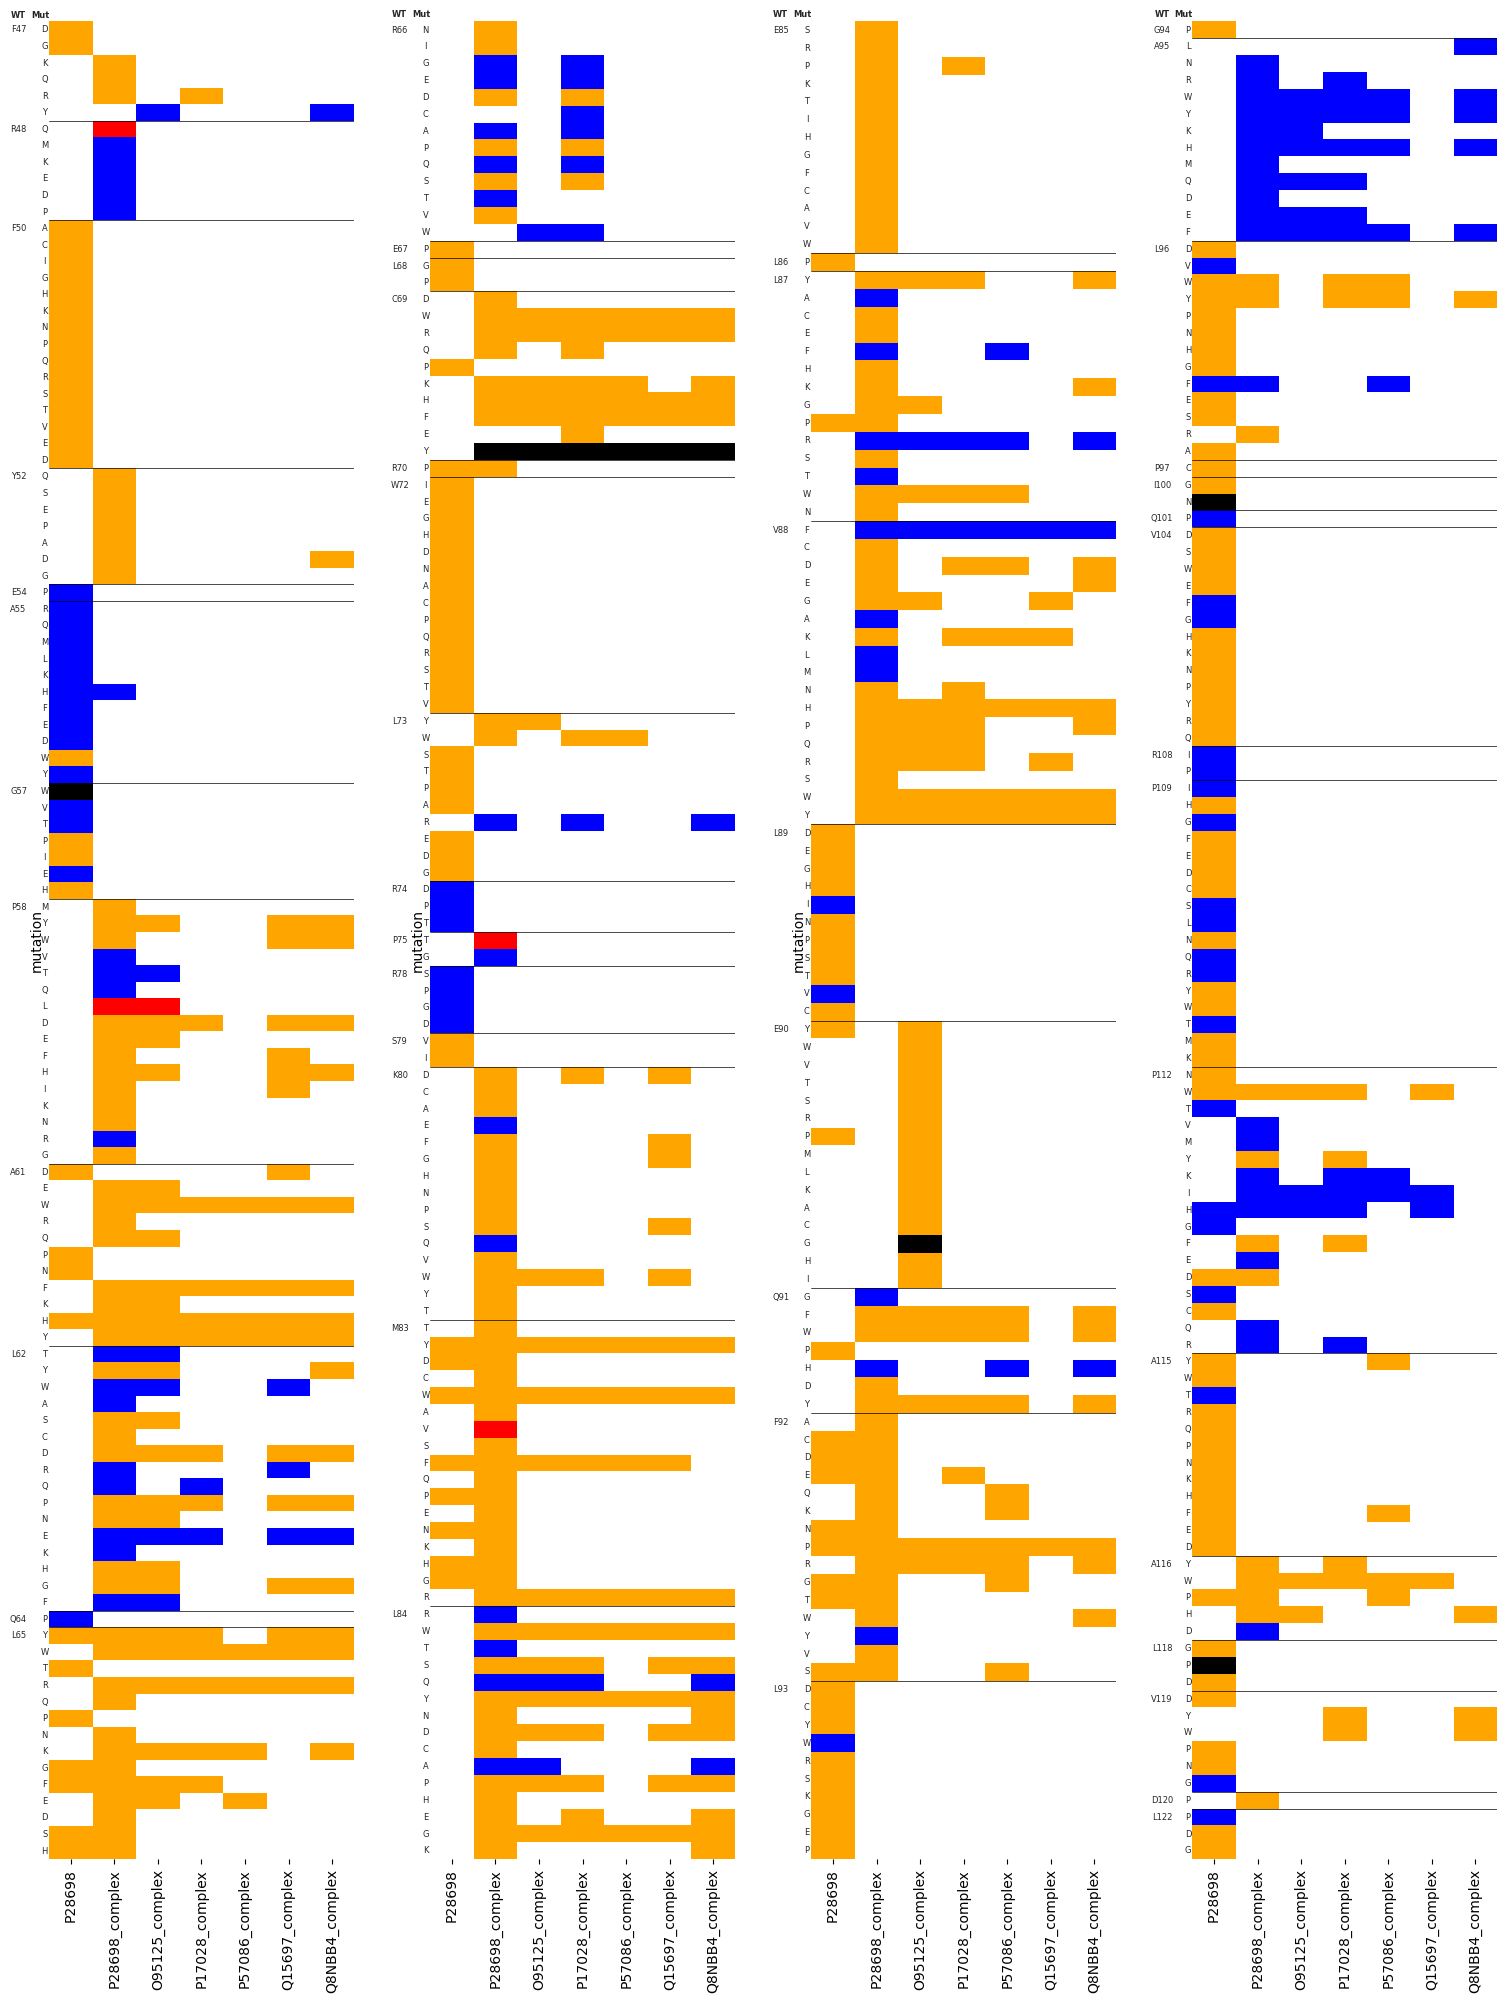

In [22]:
# Create subplot of two horizontal plots
fig, axs = plt.subplots(1, 4, figsize=(15, 20))
axs = axs.ravel()

sns.set(font_scale=0.5)
sns.set_style("whitegrid")

 
for j, combined_copy_ in enumerate([combined_copy1, combined_copy2, combined_copy3, combined_copy4]):
    if j == 0:
        ax = axs[0]
    elif j == 1:
        ax = axs[1]
    elif j == 2:
        ax = axs[2]
    elif j == 3:
        ax = axs[3]
    
    sns.heatmap(combined_copy_[proteins], cmap=cmap, norm=norm, cbar=False, ax=ax, yticklabels=False)
    ax.tick_params(axis='x', labelsize=10)  # Set the text size to 15



    # Plot y-axis labels as horizontal bars describing the common 'resi_n' for each unique number in resi_n
    ax.text(-0.2, -0.4, 'Mut', ha='center', va='center', fontweight='bold')
    ax.text(-0.7, -0.4, 'WT', ha='center', va='center', fontweight='bold')


    wt_resi_n_plotted = []
    for i, wt_resi_n in enumerate(combined_copy_['wt_resi_n']):
        if wt_resi_n not in wt_resi_n_plotted:
            ax.text(-0.7, i+0.5, wt_resi_n, ha='center', va='center')
            wt_resi_n_plotted.append(wt_resi_n)
        
        ax.text(-0.1, i+0.5, combined_copy_['mut_aa'][i], ha='center', va='center')

        # Plot a bar at the end of each unique resi_n
        if i > 0 and wt_resi_n != combined_copy_['wt_resi_n'][i-1]:
            ax.axhline(i, color='black', linewidth=0.5)
        

plt.ylabel('')  # Remove the y-axis label


"""# Create a separate colorbar
cbar = plt.colorbar(ax.collections[0],
                    ax=axs[-1], label='Category',
                    ticks=[0.5, 1.5, 2.5, 3.5, 4.5],
                    shrink =0.3,
                    format=mticker.FuncFormatter(lambda val, loc: list(int_mapping.keys())[int(val)]))
cbar.set_label('Category', rotation=270, labelpad=15, size=15)

cbar.ax.tick_params(labelsize=10)  # Set the text size to 10"""


plt.yticks(rotation=0)
plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
fig.savefig(f'../results/heatmaps_all.png', dpi=500)
print(ax.collections[0])

/tmp/ipykernel_703/122248232.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(-0.1, i+0.5, combined_copy_['mut_aa'][i], ha='center', va='center')
/tmp/ipykernel_703/122248232.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if i > 0 and wt_resi_n != combined_copy_['wt_resi_n'][i-1]:
/tmp/ipykernel_703/122248232.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(-0.1, i+0.5, combined_copy_['mut_aa'][i], ha='

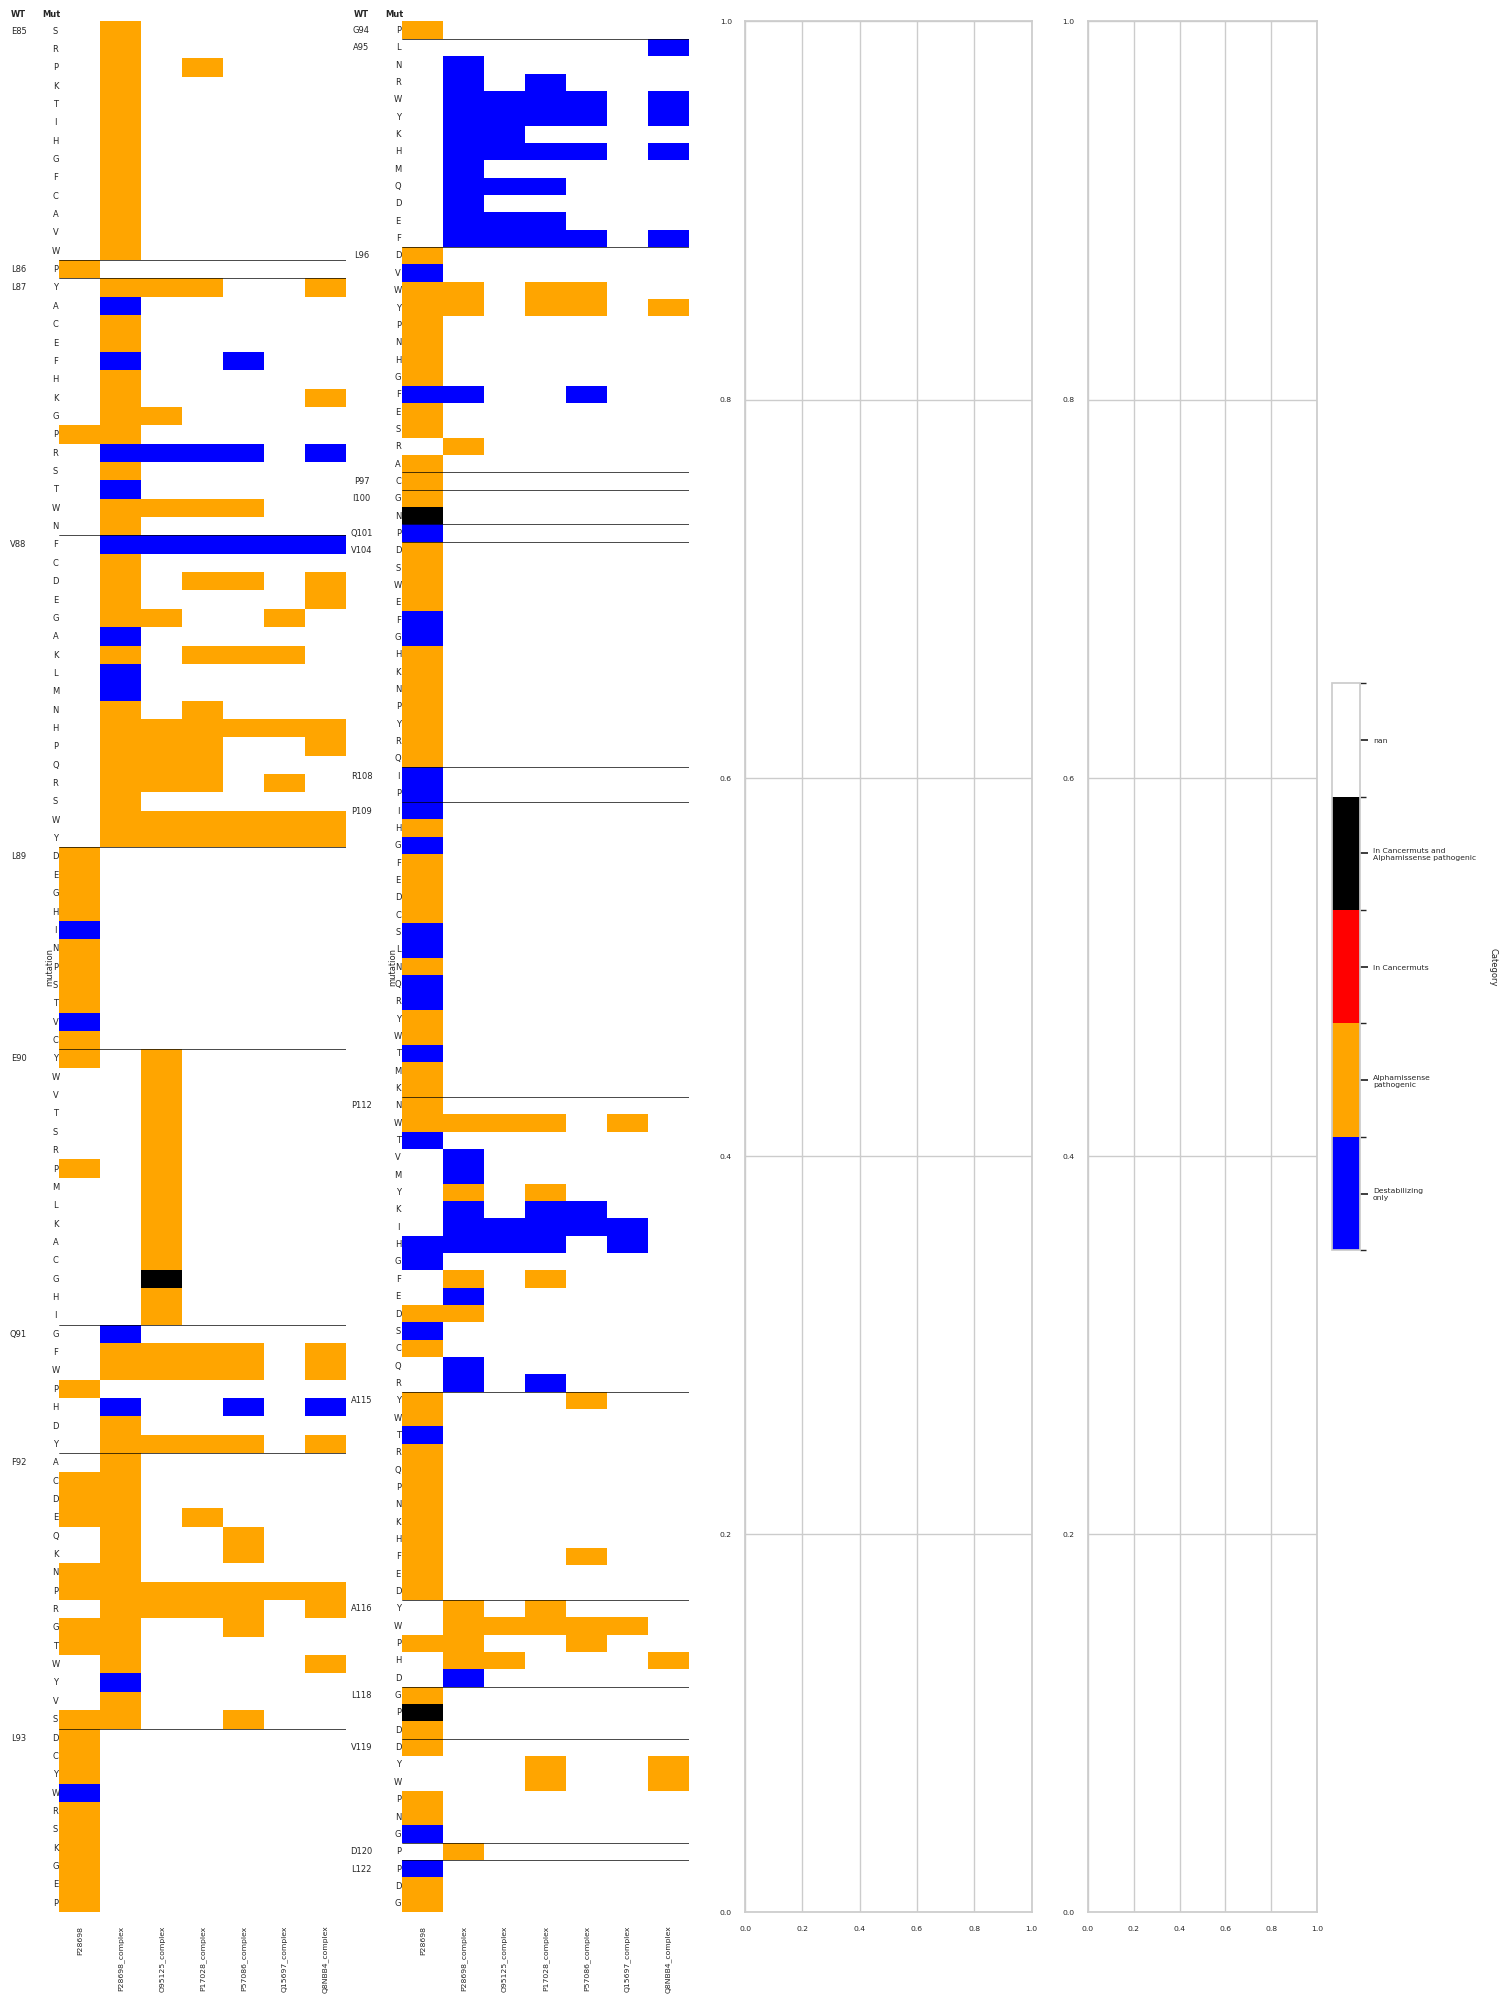

In [23]:
# Create subplot of two horizontal plots
fig, axs = plt.subplots(1, 4, figsize=(15, 20))
axs = axs.ravel()

sns.set(font_scale=0.5)
sns.set_style("whitegrid")

 
for j, combined_copy_ in enumerate([combined_copy3, combined_copy4]):
    if j == 0:
        ax = axs[0]
    elif j == 1:
        ax = axs[1]
    elif j == 2:
        ax = axs[2]
    elif j == 3:
        ax = axs[3]
    
    sns.heatmap(combined_copy_[proteins], cmap=cmap, norm=norm, cbar=False, ax=ax, yticklabels=False)



    # Plot y-axis labels as horizontal bars describing the common 'resi_n' for each unique number in resi_n
    ax.text(-0.2, -0.4, 'Mut', ha='center', va='center', fontweight='bold')
    ax.text(-1, -0.4, 'WT', ha='center', va='center', fontweight='bold')


    wt_resi_n_plotted = []
    for i, wt_resi_n in enumerate(combined_copy_['wt_resi_n']):
        if wt_resi_n not in wt_resi_n_plotted:
            ax.text(-1, i+0.5, wt_resi_n, ha='center', va='center')
            wt_resi_n_plotted.append(wt_resi_n)

        ax.text(-0.1, i+0.5, combined_copy_['mut_aa'][i], ha='center', va='center')

        # Plot a bar at the end of each unique resi_n
        if i > 0 and wt_resi_n != combined_copy_['wt_resi_n'][i-1]:
            ax.axhline(i, color='black', linewidth=0.5)
        

plt.ylabel('')  # Remove the y-axis label


# Create a separate colorbar
cbar = plt.colorbar(ax.collections[0],
                    ax=axs[-1], label='Category',
                    ticks=[0.5, 1.5, 2.5, 3.5, 4.5],
                    shrink =0.3,
                    format=mticker.FuncFormatter(lambda val, loc: list(int_mapping.keys())[int(val)]))
cbar.set_label('Category', rotation=270, labelpad=15)



plt.yticks(rotation=0)
plt.tight_layout()
fig.savefig(f'../results/01_heatmaps.png', dpi=500)
print(ax.collections[0])

In [24]:
# Grab all unique r'(w\d+)' in cmut_scan_mut
import re
wt_resi_n = []
for mut in cmut_scan_muts:
    wt_resi_n.append(re.search(r'(\w\d+)', mut).group(0))

# Get unique
wt_resi_n = list(set(wt_resi_n))
print(len(wt_resi_n))

# Check how many unique wt_resi_n are in combined_copy
unique_wt_resi_n = list(set(combined_copy['wt_resi_n']))

# Count how many unique wt_resi_n are in unique_wt_resi_n
count = 0
for wt in wt_resi_n:
    if wt in unique_wt_resi_n:
        count += 1

print(count, len(wt_resi_n), len(unique_wt_resi_n))

32
18 32 51


In [25]:
# Count number of times 2.0 appears in combined_copy
count = 0
list_of_prot = ['P28698',
                'P28698_complex',	
                'O95125_complex',	
                'P17028_complex',	
                'P57086_complex',	
                'Q15697_complex',	
                'Q8NBB4_complex']
for row in combined_copy[list_of_prot].iterrows():
    for entry in list(row)[1]:
        if entry == 2.0:
            count += 1


count

5

In [26]:
combined_copy

,mutation,P28698,P28698_complex,O95125_complex,P17028_complex,P57086_complex,Q15697_complex,Q8NBB4_complex,resi_n,wt_resi_n,mut_aa
0,F47D,1.0,4.0,4.0,4.0,4.0,4.0,4.0,47,F47,D
1,F47G,1.0,4.0,4.0,4.0,4.0,4.0,4.0,47,F47,G
2,F47K,4.0,1.0,4.0,4.0,4.0,4.0,4.0,47,F47,K
3,F47Q,4.0,1.0,4.0,4.0,4.0,4.0,4.0,47,F47,Q
4,F47R,4.0,1.0,4.0,1.0,4.0,4.0,4.0,47,F47,R
...,...,...,...,...,...,...,...,...,...,...,...
427,V119G,0.0,4.0,4.0,4.0,4.0,4.0,4.0,119,V119,G
428,D120P,4.0,1.0,4.0,4.0,4.0,4.0,4.0,120,D120,P
429,L122P,0.0,4.0,4.0,4.0,4.0,4.0,4.0,122,L122,P
430,L122D,1.0,4.0,4.0,4.0,4.0,4.0,4.0,122,L122,D


### Create a collection dataframe of mutations present in cmut and their ddgs in all the dataframe in energies_df_dict

In [27]:
cmut_mutations = []

# Get a list of mutation in cmut
for index, row in cmut_scan.iterrows():
    # Get the mutation
    mutation = row['ref_aa'] + str(row['aa_position']) + row['alt_aa']
    cmut_mutations.append(mutation)

# Create dataframe for the mutations
cmut_ddgs_df = pd.DataFrame(cmut_mutations, columns=['Mutation'])

# Left join alphamissense into cmut_ddgs_df
cmut_ddgs_df = cmut_ddgs_df.merge(alphamissense, how='left', left_on='Mutation', right_on='protein_variant')
cmut_ddgs_df = cmut_ddgs_df.drop(columns=['protein_variant', 'uniprot_id'])

# Loop over each protein structure and add ddgs for each mutation
for protein, energies_df in energies_df_dict.items():
    ddgs_protein = []
    for index, row in cmut_scan.iterrows():
        # Get the mutation
        ref_aa = row['ref_aa']
        mut_pos = row['aa_position']
        mut_aa = row['alt_aa']

        # Check if cmut mutation position is in the energies_df
        if mut_pos in energies_df['Residue #'].values:
            ddg_row = energies_df[energies_df['Residue #'] == mut_pos]
            
            # Get the ddg
            ddgs = float(ddg_row[mut_aa].values[0])
        else:
            ddgs = None
        
        ddgs_protein.append(ddgs)
        
    cmut_ddgs_df[protein] = ddgs_protein

# Set Mutation columns as indices
cmut_ddgs_df = cmut_ddgs_df.set_index('Mutation')
cmut_ddgs_df

TypeError: can only concatenate str (not "float") to str

### Heatmapping cancermut

In [ ]:
# Get protein from cmut_ddgs_df
proteins = cmut_ddgs_df.columns[2:].values

# Create a mapping from categories to letters
mapping = {'benign': 'B', 'ambiguous': 'A', 'pathogenic': 'P'}

# Create a reverse mapping from letters to integer values
def reverse_map(x):
    reverse_map_dict = {'A': 0,
                        'B': 1,
                        'P': 2}
    for key, value in reverse_map_dict.items():
        if x == key:
            return value


# Apply the mapping to the 'pathogenicity_class' column
cmut_ddgs_df['am_class'] = cmut_ddgs_df['am_class'].map(mapping)

plt.figure(figsize=(10, 17))

#
#colors = ["purple", "blue", "white", "yellow", "red"]
#bounds = np.array([-np.inf, -5, -2, 2, 5, np.inf])

# Define custom color mapping
colors = sns.color_palette(["purple", "blue", "white", "white", "yellow", "red"])
thresholds = [-np.inf, -STABILITY_THRESHOLD, 0, STABILITY_THRESHOLD, STABILITY_THRESHOLD*2, np.inf]

ax1 = sns.heatmap(cmut_ddgs_df[proteins], cmap=colors, center=0, cbar=False, vmin=-9, vmax=9)

# Create a new axis for the colorbar at the bottom of the figure
cbar_ax = plt.gcf().add_axes([0, 0.1, 0.02, 0.2])

# Create the colorbar
cbar = plt.colorbar(ax1.collections[0], cax=cbar_ax, orientation='vertical')

# Set the label for the colorbar
cbar.set_label(r'$\Delta$$\Delta$G', rotation=270, labelpad=-40)

# Create a new axis for the second heatmap
ax2 = plt.gcf().add_axes([.91, ax1.get_position().y0, .03, ax1.get_position().height])

# Create the second heatmap for the 'pathogenicity_class' column
sns.heatmap(cmut_ddgs_df['am_class'].apply(lambda x: reverse_map(x)).to_frame(), annot=cmut_ddgs_df[['am_class']], fmt='', cbar=False, yticklabels=False, ax=ax2)

# Remove y-axis label for the second heatmap
ax2.set_ylabel('')

plt.savefig('../results/ddgs_heatmap.png', dpi=300, bbox_inches='tight')

NameError: name 'STABILITY_THRESHOLD' is not defined

<Figure size 1000x1700 with 0 Axes>

In [ ]:
# Check amount of mutations above 2 ddgs in P28698_complex
P28698_complex_ddgs = cmut_ddgs_df['O95125_complex']
P28698_complex_ddgs_above_2 = P28698_complex_ddgs[P28698_complex_ddgs > STABILITY_THRESHOLD]
n_mutations_above_2 = P28698_complex_ddgs_above_2.shape[0]
n_mutations_above_2

3

# Distribution with or without cmut

#### Calculating the probability of being a stabilizing/destabilizing mutation in P28698

In [ ]:
# Get all amino acids that are stabilizing in the P28698 protein
mutation_columns = P28698_energies.columns[3:].values

# Each row, sum number of stabilizing mutations in mutation_columns
P28698_energies['n_stabilizing'] = P28698_energies[mutation_columns].apply(lambda x: x[x > STABILITY_THRESHOLD].count(), axis=1)
P28698_energies['n_destabilizing'] = P28698_energies[mutation_columns].apply(lambda x: x[x < -STABILITY_THRESHOLD].count(), axis=1)

# Divide by the amount of mutations
n_mutations = P28698_energies.shape[0] * 20

# Sum n_stabilizing and divide by n_mutations
stabilization_rate = P28698_energies['n_stabilizing'].sum() / n_mutations
destabilization_rate = P28698_energies['n_destabilizing'].sum() / n_mutations
stabilization_rate, destabilization_rate


(0.125, 0.0)

In [ ]:
n_mutations_cmut = cmut_ddgs_df.shape[0]
n_stabilizing_cmut = (cmut_ddgs_df['P28698'] > STABILITY_THRESHOLD).sum()
n_stabilizing_cmut / n_mutations_cmut

0.075

#### Calculating the probability of being a stabilizing mutation in complexes

In [ ]:
from scipy.stats import binom

probability_df_columns = ['protein', 'all_mutations_stabilization_rate', 'cmut_stabilization_rate', 'p_of_drawing_n_stabilizing_cmut_based_on_all_mutations_stabilization_rate']
probability_df = pd.DataFrame(columns=probability_df_columns)

for protein, energies_df in energies_df_dict.items():
    mutation_columns = energies_df.columns[3:].values
    energies_df['n_stabilizing'] = energies_df[mutation_columns].apply(lambda x: x[x > STABILITY_THRESHOLD].count(), axis=1)
    energies_df['n_destabilizing'] = energies_df[mutation_columns].apply(lambda x: x[x < -STABILITY_THRESHOLD].count(), axis=1)
    
    n_mutations = energies_df.shape[0] * 20
    n_stabilizing_all_mutations = energies_df['n_stabilizing'].sum()
    n_destabilizing_all_mutations = energies_df['n_destabilizing'].sum()

    stabilization_rate_all_mutations = n_stabilizing_all_mutations / n_mutations
    destabilization_rate_all_mutations = n_destabilizing_all_mutations / n_mutations

    # Get only mutations from cmut, which are also calculated in the energies_df
    # This means all mutations for the single protein, while only mutations at positions which are interface proteins for the complexes
    cmut_ddgs_df_cur = cmut_ddgs_df.copy()
    cmut_ddgs_df_cur.dropna(subset=[protein], inplace=True)
    n_mutations_cmut = cmut_ddgs_df_cur.shape[0]
    n_stabilizing_cmut = (cmut_ddgs_df_cur[protein] > STABILITY_THRESHOLD).sum()
    cmut_stabilization_rate =n_stabilizing_cmut / n_mutations_cmut

    # Calculate the probability of drawing at least n_stabilizing_cmut with a probability of stabilization_rate
    # aka. the probability of drawing the amount of stabilizing mutations we see in the cmut dataset, based on the probability of stabilizing mutations in the P28698 protein complex
    p = stabilization_rate_all_mutations
    n = n_mutations_cmut
    k = n_stabilizing_cmut
    p_of_drawing_n_stabilizing_cmut = 1 - (1- binom.cdf(k - 1, n, p))

    # Create dataframe of protein, stabilization_rate, cmut_stabilization_rate, p_of_drawing_n_stabilizing_cmut
    current_df = pd.DataFrame([[protein, stabilization_rate_all_mutations, cmut_stabilization_rate, p_of_drawing_n_stabilizing_cmut]], columns=probability_df_columns)

    probability_df = pd.concat([probability_df, current_df], axis=0)

    print(protein, round(stabilization_rate_all_mutations,4), round(cmut_stabilization_rate,4), round(p_of_drawing_n_stabilizing_cmut,4))

probability_df

P28698 0.136 0.075 0.0769
P28698_complex 0.1959 0.1724 0.3027
O95125_complex 0.0774 0.1 0.5867
P17028_complex 0.071 0.0345 0.1183
P57086_complex 0.0443 0.0385 0.3082
Q15697_complex 0.0456 0.0435 0.3417
Q8NBB4_complex 0.0541 0.0357 0.2107


/tmp/ipykernel_699/4291535197.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  probability_df = pd.concat([probability_df, current_df], axis=0)


,protein,all_mutations_stabilization_rate,cmut_stabilization_rate,p_of_drawing_n_stabilizing_cmut_based_on_all_mutations_stabilization_rate
0,P28698,0.135976,0.075000,0.076937
0,P28698_complex,0.195902,0.172414,0.302708
0,O95125_complex,0.077419,0.100000,0.586682
0,P17028_complex,0.070968,0.034483,0.118275
0,P57086_complex,0.044262,0.038462,0.308182
0,Q15697_complex,0.045614,0.043478,0.341706
0,Q8NBB4_complex,0.054098,0.035714,0.210711


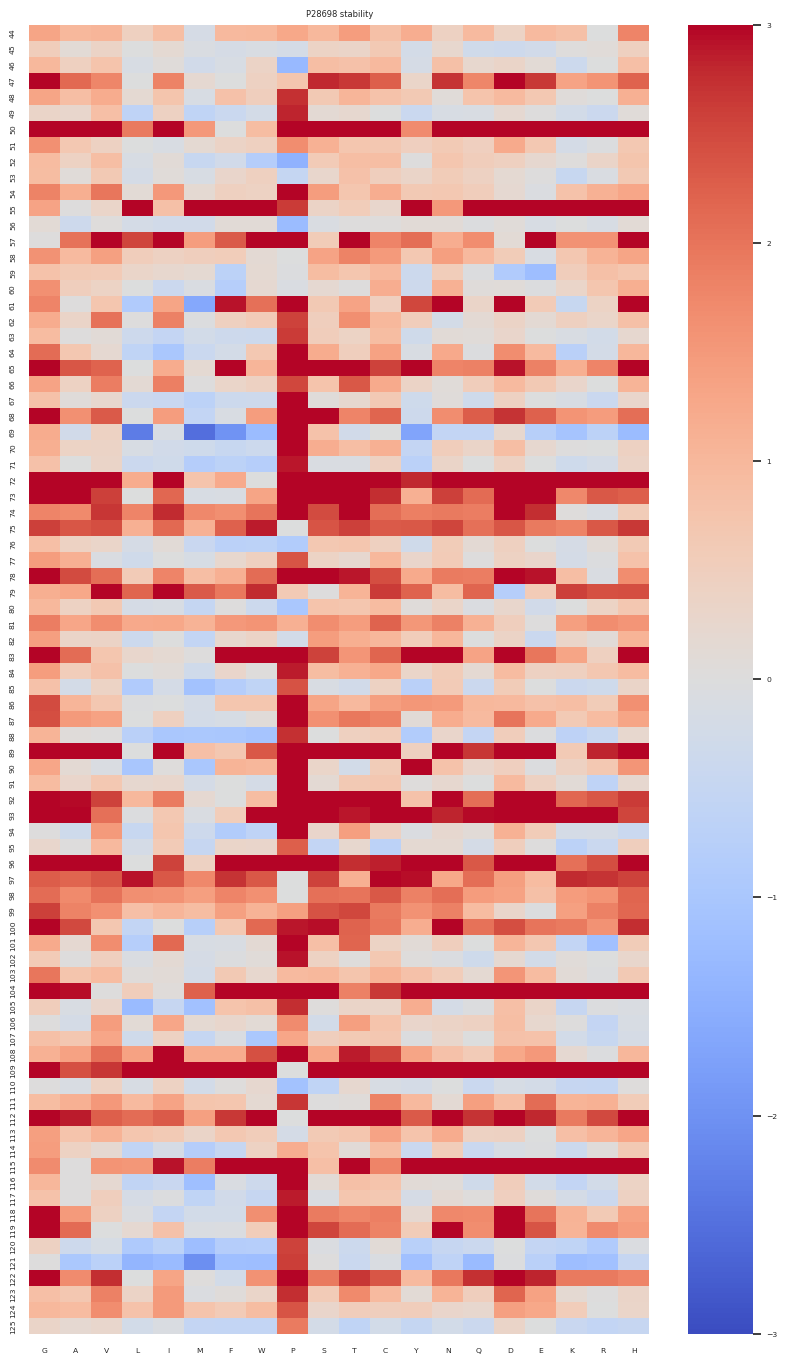

In [ ]:
# Define amino acid columns
amino_acids = ['G', 'A', 'V', 'L', 'I', 'M', 'F', 'W', 'P', 'S', 'T', 'C', 'Y', 'N', 'Q', 'D', 'E', 'K', 'R', 'H']

for protein, energies_df in energies_df_dict.items():
    # Create a heatmap of the energies_df amino_acids columns
    plt.figure(figsize=(10, 17))
    ax = sns.heatmap(energies_df[amino_acids], cmap='coolwarm', center=0, cbar=True, vmin=-3, vmax=3)

    # Set y-axis labels as 'Residue #' column values
    ax.set_yticklabels(energies_df['Residue #'])

    # Add title
    plt.title(f'{protein} stability')


    plt.savefig(f'../results/{protein}_ddgs_heatmap.png', dpi=300, bbox_inches='tight')
    break


In [ ]:
from scipy.stats import ttest_ind

for protein, energies_df in energies_df_dict.items():
    # Perform t-test for row against nearest 10 rows
    # Create a list for storing p-values
    p_values = []

    # Loop over each row in the energies_df
    for index, row in energies_df.iterrows():
        # Get the row number
        row_number = index

        # Get the row values
        row_values = row[3:-2].values


        # Get the nearest 10 rows
        nearest_rows = energies_df.iloc[max(row_number-5, 0):min(row_number+5, energies_df.shape[0])]

        print(nearest_rows.shape)

        # Loop over each nearest row
        for nearest_index, nearest_row in nearest_rows.iterrows():h
            # Get the nearest row values
            nearest_row_values = nearest_row[3:-2].values

            # Perform t-test
            t_statistic, p_value = ttest_ind(row_values, nearest_row_values, equal_var=False)

            # Append p-value to list
            p_values.append(p_value)

    

IndentationError: unexpected indent (2391567216.py, line 25)